# Reverse SuCOS scoring method

1. Break designed compound into bits at rotable bonds
2. SuCOS score these individual bits to all the fragments - a high sucCOS score would indicate that the shape/chem feature of the bit is best captured by that fragment
3. Capture best matching fragment IDs and bits
4. Get mean reverse SuCOs score
5. All fragment matches captured in sdf file
6. Top fragment matches with reverse SuCOS scores of > 0.70 also captured in sdf file

In [1]:
from rdkit.Chem.Lipinski import RotatableBondSmarts
from rdkit.Chem import BRICS
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit import RDConfig
import os
import numpy as np
import pandas as pd

def getBits(mol):
    '''

    Parameters
    ----------
    mol : rdkit mol object to be broken up into fragments by breaking 
    rotable bonds

    Returns
    -------
    mols : A list of rdkit mol objects

    '''
    # find the rotatable bonds
    bonds = mol.GetSubstructMatches(RotatableBondSmarts)
    
    bonds = [((x,y),(0,0)) for x,y in bonds]
    p = BRICS.BreakBRICSBonds(mol,bonds=bonds)
 
    mols = [mol for mol in Chem.GetMolFrags(p,asMols=True)]
    
    return mols

# Function to build feature maps and score two mol objects
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def getFeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.All):
    try: 
        featLists = []
        for m in [small_m, large_m]:
            rawFeats = fdef.GetFeaturesForMol(m)
            # filter that list down to only include the ones we're intereted in
            featLists.append([f for f in rawFeats if f.GetFamily() in keep])
        fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
        fms[0].scoreMode = score_mode
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        return fm_score
    except ZeroDivisionError:
        return 0

def getNumberfeats(mol):
    
    featLists = []
    rawFeats = fdef.GetFeaturesForMol(mol)
    # filter that list down to only include the ones we're intereted in
    featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    
    return len(featLists)

In [2]:
# Read in fragment mols
frag_mol_folder = 'in_data/score_3_hop/fragment_mols'
path  = frag_mol_folder + '/'
frag_mol_list = [Chem.MolFromMolFile((path + mol_file), sanitize=True) for mol_file in os.listdir(frag_mol_folder)]

In [3]:
# Use of we want to load docking sdf file
compound_mols = Chem.SDMolSupplier('out_data/score_3_hop/Top_10_poses_XCOS_heavyfeat_compounds.sdf')

In [4]:
compound_mols[31].GetProp('_Name')

'Exp_31'

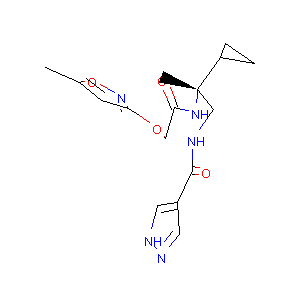

In [5]:
# Let's have a look at the first mol as an example
Chem.Draw.MolToImage(compound_mols[31])

In [6]:
# Let's break the first mol into bits 
compound_bits = getBits(compound_mols[31])

In [7]:
test_atoms = compound_bits[4]

In [8]:
Chem.MolToSmiles(test_atoms)

'[*]N[*]'

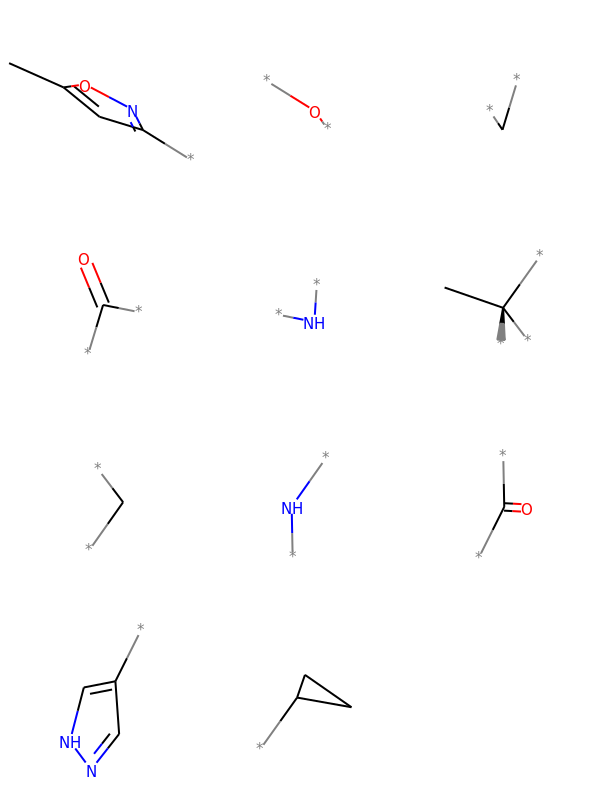

In [9]:
# What are the bits?
Draw.MolsToGridImage(compound_bits, molsPerRow=3)

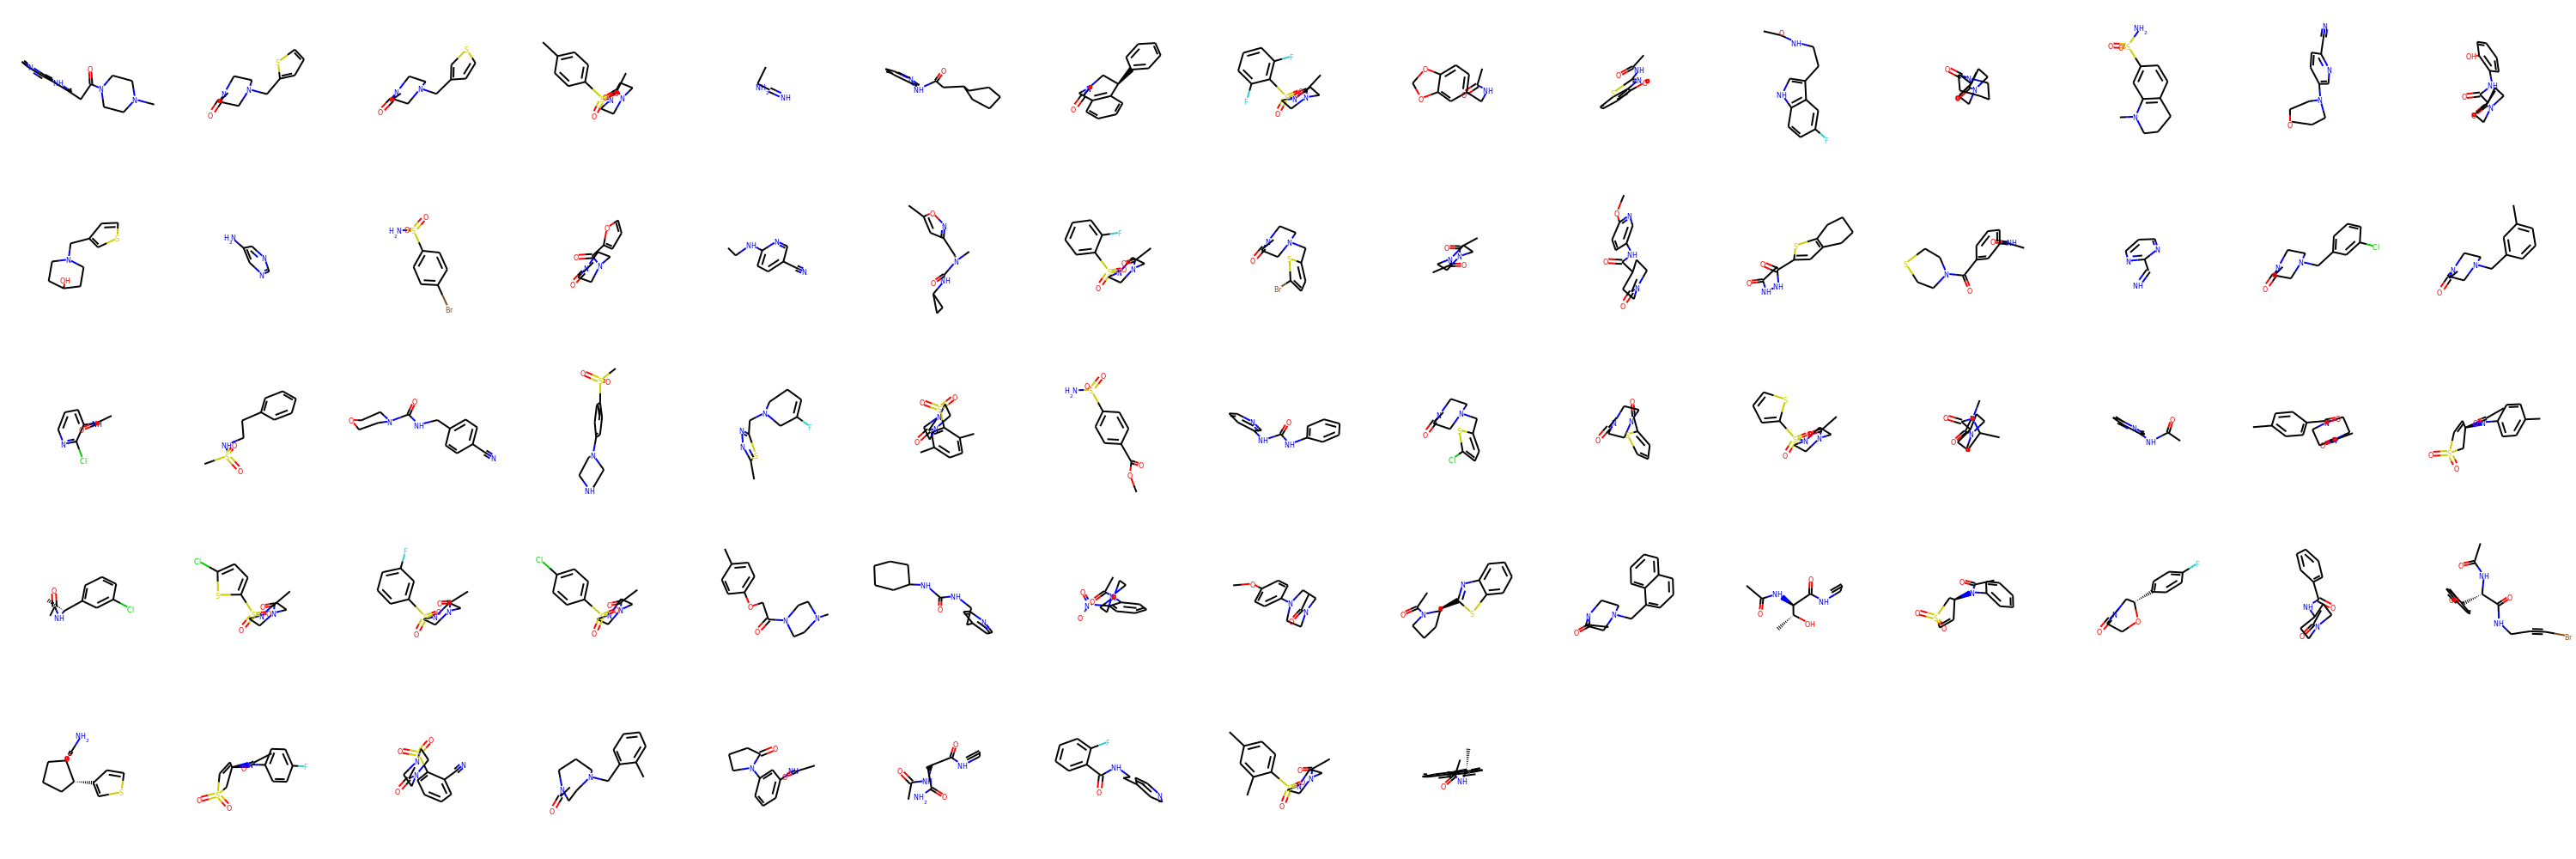

In [10]:
# What do the frags look like
Draw.MolsToGridImage(frag_mol_list, molsPerRow=15)

In [35]:
# Let's score docked bits to fragment mols
all_scores = []
for bit in compound_bits:
    scores = []
    for frag_mol in frag_mol_list:
            # NB reverse SuCOS scoring
            fm_score = getFeatureMapScore(bit, frag_mol)
            fm_score = np.clip(fm_score, 0, 1)             
            protrude_dist = rdShapeHelpers.ShapeProtrudeDist(bit, frag_mol,
                                                             allowReordering=False,
                                                             vdwScale=0.1)
            protrude_dist = np.clip(protrude_dist, 0, 1)
            reverse_SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
            
            # Get some info and append to list
            frag_name = frag_mol.GetProp('_Name')
            
            scores.append((frag_name, reverse_SuCOS_score))
    all_scores.append(scores)
            

In [36]:
len(all_scores)

11

In [37]:
# Let's stay with bit 1 and see if we can do some filtering
# Cool so we have some scores! Can we filter these scores to yield fragemnt 
# with highest matching score and/or fragments with same score?
bit_1_scores = all_scores[0]
bit_1_df = pd.DataFrame(data=bit_1_scores, columns = ['Fragment','Score'])
bit_1_df.head()

,Fragment,Score
0,Mpro-x1093,0.380846
1,Mpro-x1418,0.000000
2,Mpro-x1386,0.000000
3,Mpro-x0731,0.000000
4,Mpro-x0991,0.000000


In [38]:
# What is the max score?
bit_1_df.iloc[bit_1_df['Score'].idxmax()]

Fragment    Mpro-x0678
Score           0.6526
Name: 5, dtype: object

In [39]:
# Ok but do really have a single winner? Let's check for multiple wins
 bit_1_df[bit_1_df['Score'] == bit_1_df['Score'].max()]

,Fragment,Score
5,Mpro-x0678,0.6526


In [40]:
# Let's look at comparing all the bits and their scores looking for any
# multiple matches
list_dfs = [] 
for score in all_scores:
    df = pd.DataFrame(data=score, columns = ['Fragment','Score'])
    df = df[df['Score'] == df['Score'].max()]
    list_dfs.append(df)

final_df = pd.concat(list_dfs)
final_df

,Fragment,Score
5,Mpro-x0678,0.652600
5,Mpro-x0678,0.127052
0,Mpro-x1093,0.436731
60,Mpro-x0874,0.870341
0,Mpro-x1093,0.655280
32,Mpro-x1249,0.347625
54,Mpro-x0830,0.257968
49,Mpro-x0354,0.604332
53,Mpro-x0749,0.344903
4,Mpro-x0991,0.366181


In [14]:
# Let's get unique fragment ids
unique_frags = pd.unique(final_df.Fragment)
unique_frags

array(['Mpro-x0426'], dtype=object)

In [15]:
# Double check for multiple matches by comparing length df with number of bits
len(final_df) == len(compound_bits)

True

## Get aggregated features using nearest neigbours algo

- Did try feature merge using Tim's feature merge function from FeatureStein but was unable to run code

In [16]:
from sklearn.neighbors import NearestNeighbors

# We need to start by building a FeatureFactory object which defines 
# the set of pharmacophore features being used. 
# We'll use this to find features on the molecules.
fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 
                                                'BaseFeatures.fdef'))


# Set default paramters for selecting points in feature map
fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

# List of feature families that we want to use
keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')


def getFeatureMap(mol_list):
    allFeats = []
    for m in mol_list:
        
        rawFeats = fdef.GetFeaturesForMol(m)
        featDeats = [(f.GetType(),
                      f.GetPos().x,
                      f.GetPos().y,
                      f.GetPos().z) for f in rawFeats if f.GetFamily() in keep]
        
        allFeats.append(featDeats)
        

    feature_map_df = pd.DataFrame([t for lst in allFeats for t in lst],
                                  columns =['featType', 'x', 'y', 'z']) 
   
    return feature_map_df


def getFeatureAgg(feature_map_df, rad_thresh, filename):
    
    # Group data into unique feature types
    grouped_df = feature_map_df.groupby('featType')
    
    data_to_add = []
    
    for group_name, df_group in grouped_df:
        
        # Reset index df
        df_group = df_group.reset_index()

        if len(df_group) == 1:
            
            data_to_add.append(df_group)
        
        if len(df_group) > 1:
                
            # Get feature name
            feat_name = df_group.featType.unique()[0]

            # Use radius neighbours to find features within 
            # spere with radius thresh
            neigh = NearestNeighbors(radius=rad_thresh)
            
            while len(df_group) > 0:
                
                neigh.fit(df_group[['x','y','z']])
            
                # Get distances and indices of neigbours within radius threshold
                rng = neigh.radius_neighbors()
                neigh_dist = rng[0][0]
                neigh_indices = rng[1][0]
                
                # Append the first index - NB clustering done relative to index 0
                neigh_indices = list(np.append(0, neigh_indices))
                
                # Calculate average x,y,z coords for features in similar loc
                x_avg = np.mean(df_group.iloc[neigh_indices].x)
                y_avg = np.mean(df_group.iloc[neigh_indices].y)
                z_avg = np.mean(df_group.iloc[neigh_indices].z)
                
                # Add feature with average x, y and z values
                new_row = [(feat_name, x_avg, y_avg, z_avg)]
                
                cluster_df = pd.DataFrame(data=new_row, columns = ['featType', 'x', 'y', 'z'])
                
                data_to_add.append(cluster_df)
                
                # Remove indices of clustered neigbours
                df_group = df_group.drop(df_group.index[neigh_indices])
        
    # Create single DF from list of dfs
    clustered_df = pd.concat(data_to_add)

    return clustered_df

    def getSDFprops(compound_mol):


In [17]:
# Get the feature map df with coordinates and feature info
feature_map_df =  getFeatureMap(frag_mol_list)

# Set radius threshold 
rad_thresh = 1.5

# Aggregate features using nearest neigbours algo
clustered_df = getFeatureAgg(feature_map_df,
                             rad_thresh=rad_thresh,
                             filename='agg_frags')

# Get number of clustered feats
no_clustered_feats = len(clustered_df)
print('{} clustered features found with radius threshold {}'.format(no_clustered_feats, rad_thresh))

175 clustered features found with radius threshold 1.5


In [18]:
def getReverseScores(clustered_df, compound_mols, rad_threshold, 
                     COS_threshold, filename):
    
    # Get writer set up for writing final mols to file
    w = Chem.SDWriter(filename)
    
    # Score eveything besides for first mol
    for compound_mol in compound_mols:
        
        if compound_mol == compound_mols[0]:
            

        # Get the bits
        compound_bits = getBits(compound_mol)
        
        # We are going to include a feature mapping score, where the 
        # number of features of the compound matching the clustered feats 
        # within a threshold are found
        
        # Get feature map of compound bits as df
        feature_map_bits = getFeatureMap(compound_bits)
        
        # Group data into unique feature types
        grouped_df = feature_map_bits.groupby('featType')
        
        no_feats_matched = []
        dist_feats_matched = []

        # Use radius neighbours to find features within 
        # spere with radius thresh
        neigh = NearestNeighbors(radius=rad_threshold)
        
        # Loop through grouped features
        for group_name, df_group in grouped_df:          

            # Get feat name
            feat_name = df_group.featType.unique()[0]

            # Get simmilar feats from cluster df
            cluster_test = clustered_df[clustered_df.featType==feat_name]
            
            # Reset index df
            df_group = df_group.reset_index()
            
            if len(cluster_test) == 1:
                
                # Calculate distances
                x1_sub_x2 = (cluster_test.iloc[0].x - df_group.iloc[0].x)**2
                y1_sub_y2 = (cluster_test.iloc[0].y - df_group.iloc[0].y)**2
                z1_sub_z2 = (cluster_test.iloc[0].z - df_group.iloc[0].z)**2
            
                diff_sum = x1_sub_x2 + y1_sub_y2 + z1_sub_z2
            
                dist = diff_sum**0.5
                
                if dist < rad_threshold:
                    
                    # Let's get the number of feats matched
                    no_feats_matched.append(1)

                    # Let's get the distance of the feats matched
                    dist_feats_matched.append([dist])                
            
            if len(cluster_test) > 1:
                neigh.fit(cluster_test[['x','y','z']])
                    
                while len(df_group) > 0:

                    # Get distances and indices of neigbours within radius threshold
                    feat_coords = [[df_group.iloc[0].x, df_group.iloc[0].y, df_group.iloc[0].z]]
                    rng = neigh.radius_neighbors(feat_coords)

                    neigh_dist = rng[0][0]
                    neigh_indices = rng[1][0]

                    # Let's get the number of feats matched
                    no_feats_matched.append(len(neigh_indices)

                    # Remove index 0 of df_group
                    df_group = df_group.drop(df_group.index[0])
        
        # Get total number of feat matches 
        no_feats = np.sum(no_feats_matched)
    
        all_scores = []
        
        for bit in compound_bits:
            
            # Get number of bit atoms
            no_bit_atoms = bit.GetNumAtoms()
            
            scores = []
            for frag_mol in frag_mol_list:
                                            
                    # NB reverse SuCOS scoring
                    fm_score = getFeatureMapScore(bit, frag_mol)
                    fm_score = np.clip(fm_score, 0, 1)             
                    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(bit, frag_mol,
                                                                     allowReordering=False)
                    protrude_dist = np.clip(protrude_dist, 0, 1)
                    
                    reverse_SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
                    
                    # Get number of feats from bit for scaling score
                    no_bit_feats = getNumberfeats(bit)
                    
                    # Get some info and append to list
                    frag_name = frag_mol.GetProp('_Name')

                    scores.append((frag_name, reverse_SuCOS_score, no_bit_atoms, no_bit_feats))
            
            all_scores.append(scores)

            list_dfs = [] 
            for score in all_scores:
                df = pd.DataFrame(data=score, columns = ['Fragment','Score','No_bit_atoms', 'No_bit_feats'])
                # Get maximum scoring fragment for bit match
                df = df[df['Score'] == df['Score'].max()]
                list_dfs.append(df)

            final_df = pd.concat(list_dfs)
            
            # Get total bit score and some denominator terms
            bits_score = (final_df.No_bit_atoms * final_df.Score).sum()
            total_atoms = final_df.No_bit_atoms.sum()
            
            # Score 1: the score is scaled by the fraction of bit atoms
            # to the total number of bit atoms in the compound
            score_1 = bits_score / total_atoms
            
            # Score 2: the score is scaled by the fraction of bit atoms
            # to the total number of aggregated features in the compound
            score_2 = bits_score / no_clustered_feats
                        
            # Score 3: the score is scaled by the fraction of bit atoms
            # to the total number of bit atoms multiplied by  
            # total number feats clustered
            score_3 = bits_score / (total_atoms * no_clustered_feats)
            
            # Score 4: the score is scaled by the fraction of bit atoms
            # to the total number of bit atoms multiplied (penalised) by 
            # the fraction of feats matched to total number feats clustered
            score_4 = score_1 * (no_feats / no_clustered_feats)
     
            # Let's only get frags above a threshold
            final_df = final_df[final_df.Score > COS_threshold]

            # Get the unique fragments above threshold
            all_frags = pd.unique(final_df.Fragment) 
        
    
                    
                                            

        # Get all the sdf properties
        all_properties = list(compound_mol.GetPropsAsDict().keys())

        # Properties to keep 
        keep_properties = ['Molecule Name', 'creator', 'fragments', 'link'] 

        # Properties to delete
        del_properties = [prop for prop in all_properties if prop not in keep_properties]

        for prop in del_properties:
                compound_mol.ClearProp(prop)

        # Add props we want
        compound_mol.SetProp('overlapping_fragments',','.join(all_frags))
        compound_mol.SetProp('no_overlapping_fragments', str(len(all_frags)))
        compound_mol.SetProp('no_atoms_score', "{:.4f}".format(score_1))
        compound_mol.SetProp('no_cluster_score', "{:.4f}".format(score_2))
        compound_mol.SetProp('no_atom_cluster_score', "{:.4f}".format(score_3))
        compound_mol.SetProp('feat_ratio_score', "{:.4f}".format(score_4))

        # Write to file
        w.write(compound_mol)

In [ ]:
# Let's do all of the compounds
test_df = getReverseScores(clustered_df=clustered_df, compound_mols=compound_mols,
                           rad_threshold=1.0, COS_threshold=0.7, 
                           filename='out_data/Teo_xCOS.sdf')